In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [5]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [6]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

In [7]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [8]:
df['content'] = df['title'] + " " + df['text']
df['content'] = df['content'].str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)


In [9]:
X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
selector = SelectKBest(chi2, k=5000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

In [12]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

In [13]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

In [14]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📌 {name}")
    print("Accuracy:", acc)
    print("Precision:", pre)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    results[name] = [acc, pre, rec, f1]


📌 Random Forest
Accuracy: 0.9983296213808464
Precision: 0.9983656315666589
Recall: 0.9981325863678805
F1 Score: 0.9982490953659391
Confusion Matrix:
 [[4689    7]
 [   8 4276]]

📌 Logistic Regression
Accuracy: 0.995879732739421
Precision: 0.9957973383142658
Recall: 0.9955648926237162
F1 Score: 0.9956811019026497
Confusion Matrix:
 [[4678   18]
 [  19 4265]]

📌 KNN
Accuracy: 0.7047884187082405
Precision: 0.9695227142035653
Recall: 0.39355742296918766
F1 Score: 0.5598538934086004
Confusion Matrix:
 [[4643   53]
 [2598 1686]]

📌 Decision Tree
Accuracy: 0.9956570155902005
Precision: 0.9955638571095027
Recall: 0.9953314659197012
F1 Score: 0.9954476479514416
Confusion Matrix:
 [[4677   19]
 [  20 4264]]


In [19]:
voting_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"])
    ],
    voting='hard'
)
voting_model.fit(X_train_scaled, y_train)
y_vote = voting_model.predict(X_test_scaled)

model_names = []
for name, model in voting_model.estimators:
    if isinstance(model, RandomForestClassifier):
        model_names.append("Random Forest")
    elif isinstance(model, LogisticRegression):
        model_names.append("Logistic Regression")
    elif isinstance(model, KNeighborsClassifier):
        model_names.append("KNN")
    elif isinstance(model, DecisionTreeClassifier):
        model_names.append("Decision Tree")
    else:
        model_names.append(name)

# Evaluate all models to find the best one
best_model = None
best_f1 = -1
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

print(f"\n📌 Ensemble Voting Classifier (Models: {', '.join(model_names)})")
print("Accuracy:", accuracy_score(y_test, y_vote))
print("F1 Score:", f1_score(y_test, y_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_vote))
print(f"\n🏆 Best Individual Model: {best_model} (F1 Score: {best_f1:.4f})")


📌 Ensemble Voting Classifier (Models: Random Forest, Logistic Regression, Decision Tree)
Accuracy: 0.9988864142538976
F1 Score: 0.9988331388564761
Confusion Matrix:
 [[4690    6]
 [   4 4280]]

🏆 Best Individual Model: Random Forest (F1 Score: 0.9982)


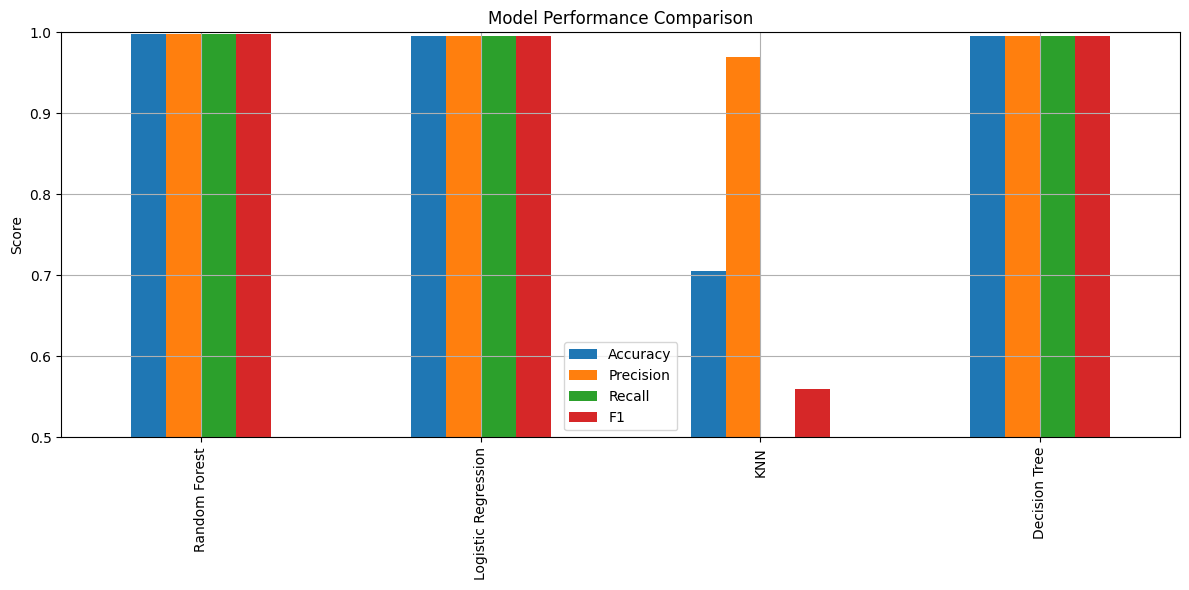

In [20]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1"]).T
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()